In [ ]:
thermo_docs

[MPDataDoc<ThermoDoc>(
 builder_meta=EmmetMeta(emmet_version='0.84.6rc3', pymatgen_version='2024.11.13', pull_request=None, database_version='2025.02.12', build_date=datetime.datetime(2025, 2, 5, 0, 27, 50, 59000), license='BY-C'),
 nsites=2,
 elements=[Element Si],
 nelements=1,
 composition=Composition('Si2'),
 composition_reduced=Composition('Si1'),
 formula_pretty='Si',
 formula_anonymous='A',
 chemsys='Si',
 volume=40.88829284866485,
 density=2.281194283537673,
 density_atomic=20.444146424332423,
 symmetry=SymmetryData(crystal_system=<CrystalSystem.cubic: 'Cubic'>, symbol='Fd-3m', number=227, point_group='m-3m', symprec=0.1, version='2.5.0'),
 property_name='thermo',
 material_id=MPID(mp-149),
 deprecated=False,
 deprecation_reasons=None,
 last_updated=datetime.datetime(2025, 2, 5, 0, 27, 50, 83000),
 origins=[PropertyOrigin(name='energy', task_id=MPID(mp-2291052), last_updated=datetime.datetime(2025, 2, 5, 0, 27, 50, 59000))],
 warnings=[],
 thermo_type=<ThermoType.GGA_GGA_U: 'GG

In [ ]:
import json
import numpy as np
from pymatgen.core import Composition, Element, Structure
from pymatgen.entries.compatibility import MaterialsProjectCompatibility
from pymatgen.entries.computed_entries import ComputedEntry
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter
from mp_api.client import MPRester

# 参数设置
API_KEY = 'iAihdZzrZYLQKZms1S43De90NiNK6ABB'
JSON_PATH = r'D:\deep\GNN\SSE\ML-HTVS-Li-SE-main\data\search_from_mp\train_extrap\all_materials_data_form_ehull.json'
OUTPUT_JSON_PATH = r'D:\deep\GNN\SSE\ML-HTVS-Li-SE-main\data\search_from_mp\train_extrap\all_materials_data_with_properties.json'
OUTPUT_CSV_PATH = r'D:\deep\GNN\SSE\ML-HTVS-Li-SE-main\data\search_from_mp\train_extrap\all_materials_data_with_properties.csv'
INTERMEDIATE_SAVE_INTERVAL = 10  # 每处理10个mp_id保存一次中间结果

def load_structure_from_cif(cif_content):
    """从 CIF 内容加载结构文件并返回结构和组成信息"""
    structure = Structure.from_str(cif_content, fmt='cif')
    comp = structure.composition
    return structure, comp

def get_chemsys(comp):
    """根据组成信息获取化学系统字符串"""
    elements = sorted(comp.elements, key=lambda el: el.symbol)
    chemsys = "-".join([el.symbol for el in elements])
    return chemsys

def fetch_entries(rester, chemsys, mp_id):
    """从Materials Project获取条目"""
    mp_entries = rester.get_entries_in_chemsys(chemsys)
    entry = rester.get_entries(mp_id)[0]
    entries = [entry] + mp_entries
    return entries

def calculate_phase_diagram(entries):
    """计算相图"""
    pd = PhaseDiagram(entries)
    return pd

def calculate_electrochemical_stability(pd, entry):
    """计算电化学稳定性"""
    li_entries = [e for e in entries if e.composition.reduced_formula == "Li"]
    uli0 = min(li_entries, key=lambda e: e.energy_per_atom).energy_per_atom

    el_profile = pd.get_element_profile(Element("Li"), entry.composition)
    voltages, reactions, evolutions = [], [], []

    for d in el_profile:
        voltage = -(d["chempot"] - uli0)
        voltages.append(voltage)
        reactions.append(d["reaction"])
        evolutions.append(d["evolution"])

    reduction_potential = min(voltages, key=lambda v: abs(evolutions[voltages.index(v)]))
    oxidation_potential = next((v for v, e in zip(voltages, evolutions) if e < -0.2), None)

    electrochemical_stability_window = (oxidation_potential - reduction_potential) if reduction_potential is not None and oxidation_potential is not None else 0
    return reduction_potential, oxidation_potential, electrochemical_stability_window

def load_json_data(json_path):
    """加载 JSON 数据"""
    with open(json_path, 'r') as f:
        data = json.load(f)
    return data

def save_json_data(data, output_path):
    """保存 JSON 数据"""
    with open(output_path, 'w') as f:
        json.dump(data, f, indent=4)

def save_csv_data(data, output_path):
    """保存 CSV 数据"""
    import csv
    keys = data[next(iter(data))].keys()
    with open(output_path, 'w', newline='') as output_file:
        dict_writer = csv.DictWriter(output_file, fieldnames=keys)
        dict_writer.writeheader()
        dict_writer.writerows(data.values())

def get_material_properties(rester, mp_id, cif_content):
    """获取材料的属性"""
    try:
        thermo_docs = rester.materials.thermo.search(material_ids=[mp_id])
        if not thermo_docs:
            raise ValueError(f"No data found for mp_id: {mp_id}")

        doc = thermo_docs[0]
        band_gap = rester.get_bandstructure_by_material_id(mp_id).get_band_gap()['energy']
        density = doc.density
        chemsys = doc.chemsys
        uncorrected_energy_per_atom = doc.uncorrected_energy_per_atom
        energy_per_atom = doc.energy_per_atom
        is_stable = doc.is_stable

        # # 计算电化学稳定性
        # structure, comp = load_structure_from_cif(cif_content)
        # chemsys = get_chemsys(comp)
        # entries = fetch_entries(rester, chemsys, mp_id)
        # pd = calculate_phase_diagram(entries)
        # reduction_potential, oxidation_potential, electrochemical_stability_window = calculate_electrochemical_stability(pd, entries[0])

        return {
            "band_gap": band_gap,
            "density": density,
            "chemsys": chemsys,
            "uncorrected_energy_per_atom": uncorrected_energy_per_atom,
            "energy_per_atom": energy_per_atom,
            "is_stable": is_stable,
            # "reduction_potential": reduction_potential,
            # "oxidation_potential": oxidation_potential,
            # "electrochemical_stability_window": electrochemical_stability_window,
        }
    except Exception as e:
        print(f"Error fetching data for {mp_id}: {e}")
        return {}

# 主程序
if __name__ == "__main__":
    rester = MPRester(api_key=API_KEY)
    json_data = load_json_data(JSON_PATH)
    updated_data = {}

    for i, (mp_id, data) in enumerate(json_data.items()):
        print(f"Processing mp_id: {mp_id}")
        cif_content = data.get("cif", "")
        if cif_content:
            properties = get_material_properties(rester, mp_id, cif_content)
            updated_data[mp_id] = {**data, **properties}
            # print(f"Updated data for {mp_id}: {updated_data[mp_id]}")
        else:
            print(f"未找到 {mp_id} 的 CIF 数据。")
        print("-" * 50)

        # 定期保存中间结果
        if (i + 1) % INTERMEDIATE_SAVE_INTERVAL == 0:
            save_json_data(updated_data, OUTPUT_JSON_PATH)
            print(f"Saved intermediate results after processing {i + 1} mp_ids.")

    # 保存最终结果
    save_json_data(updated_data, OUTPUT_JSON_PATH)
    save_csv_data(updated_data, OUTPUT_CSV_PATH)
    print("Data saved to JSON and CSV files.")
    
    

## Filters from MP

In [ ]:
import json
import numpy as np
from pymatgen.core import Structure
from mp_api.client import MPRester

# 参数设置
API_KEY = 'iAihdZzrZYLQKZms1S43De90NiNK6ABB'
rester = MPRester(api_key=API_KEY)
JSON_PATH = 'all_mp_data.json'
CSV_PATH = 'all_mp_data.csv'

# 获取所有材料的摘要信息并提取所需字段
print("Fetching materials summary from Materials Project...")

fields = ['chemsys', 'formula_pretty', 'density', 'material_id', 'structure',
          'energy_per_atom', 'formation_energy_per_atom', 'energy_above_hull', 'band_gap',
          'bulk_modulus', 'shear_modulus', 'is_stable']

all_mp = rester.materials.summary.search(fields=fields)


Fetching materials summary from Materials Project...


Retrieving SummaryDoc documents:   0%|          | 0/154987 [00:00<?, ?it/s]

In [ ]:

extracted_data = {}
for material in all_mp:
    mp_id = str(material.material_id)
    structure = material.structure
    if structure is None:
        # print(f"Skipping mp_id: {mp_id} due to missing structure.")
        continue
    cif = structure.to(fmt='cif')
    extracted_data[mp_id] = {
        "formula_pretty": material.formula_pretty,
        "cif": cif,
        "formation_energy_per_atom": material.formation_energy_per_atom,
        "energy_above_hull": material.energy_above_hull,
        "band_gap": material.band_gap,
        "bulk_modulus": material.bulk_modulus,
        "shear_modulus": material.shear_modulus,
        "is_stable": material.is_stable,
        "chemsys": material.chemsys,
        # "uncorrected_energy_per_atom": material.uncorrected_energy_per_atom,
        "energy_per_atom": material.energy_per_atom,
        "density": material.density,
    }

# 保存为JSON和CSV文件
print(f"Saving data to {JSON_PATH} and {CSV_PATH}...")
with open(JSON_PATH, 'w') as f:
    json.dump(extracted_data, f, indent=4)

import csv
keys = extracted_data[next(iter(extracted_data))].keys()
with open(CSV_PATH, 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, fieldnames=keys)
    dict_writer.writeheader()
    dict_writer.writerows(extracted_data.values())
print("Data saved successfully.")

d:\ProgramData\envs\matgl\lib\site-packages\pymatgen\core\periodic_table.py:142: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
d:\ProgramData\envs\matgl\lib\site-packages\pymatgen\core\periodic_table.py:142: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
d:\ProgramData\envs\matgl\lib\site-packages\pymatgen\core\periodic_table.py:142: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


Saving data to all_mp_data.json and all_mp_data.csv...
Data saved successfully.


In [ ]:
# begin filter 1 step

# 1，对上述的extracted_data 数据进行第一步筛选，筛选条件为 其中每个 mp_id 对应的 energy_above_hull 小于等于 0.1，而且 formula_pretty 不是单质元素,
# 对应的 mp_id 保存到 filtered_1_energy_above_hull.json 文件中

# 2，将得到的 filtered_1_energy_above_hull.json 保存为 json 文件，方便后续筛选2使用


# 假设 extracted_data 是从某个方法获取的数据列表
# 每个元素包含 mp_id, energy_above_hull, formula_pretty 等字段
# 筛选条件：energy_above_hull <= 0.1 且 formula_pretty 不是单质元素
# def is_element(formula):
#     return len(formula) == 1 or (len(formula) == 2 and formula[1].isdigit())

import json
# 判断是否为单质元素的函数
def is_element(formula):
    # 获取所有元素符号
    from pymatgen.core.periodic_table import Element
    elements = {Element.from_Z(i).symbol for i in range(1, 119)}  # 119 是当前已知元素的最大原子序数
    return formula in elements or (len(formula) == 2 and formula[0] in elements and formula[1].isdigit())

# 筛选符合条件的材料
filtered_data = {
    mp_id: entry 
    for mp_id, entry in extracted_data.items()
    if entry.get("energy_above_hull", float('inf')) <= 0.1 and not is_element(entry.get("formula_pretty", ""))
}

# 保存筛选后的数据到 filtered_1_energy_above_hull.json 文件中
with open('filtered_1_energy_above_hull.json', 'w') as f:
    json.dump(filtered_data, f, indent=4)

print("筛选完成，结果已保存到 filtered_1_energy_above_hull.json 文件中")


筛选完成，结果已保存到 filtered_1_energy_above_hull.json 文件中


In [ ]:
# 1， 基于 第1步筛选后的 filtered_data 做第2步筛选

# 2，筛选的条件为 每个 mp_id 对应的 band_gap > 3.0  同时包含Li元素 Li mole fraction>=0.1

# 3，将得到的 filtered_2_band_gap.json 保存为 json 文件，方便后续筛选3使用
import json
# 假设 filtered_data 是从第一步筛选得到的数据
# 这里我们先加载第一步筛选后的数据
# with open('filtered_1_energy_above_hull.json', 'r') as f:
#     filtered_data = json.load(f)

# 第2步筛选条件：band_gap > 3.0
filtered_data_band_gap = {
    mp_id: entry
    for mp_id, entry in filtered_data.items()
    if entry.get("band_gap") is not None and entry.get("band_gap", float('-inf')) > 3.0
}
# 保存筛选后的数据到 filtered_2_band_gap.json 文件中
with open('filtered_2_band_gap.json', 'w') as f:
    json.dump(filtered_data_band_gap, f, indent=4)

print("筛选完成，结果已保存到 filtered_2_band_gap.json 文件中")

筛选完成，结果已保存到 filtered_2_band_gap.json 文件中


In [ ]:
import json

# 假设 filtered_data 是从第一步筛选得到的数据
# with open('filtered_1_energy_above_hull.json', 'r') as f:
#     filtered_data = json.load(f)

# 第2步筛选条件：band_gap > 3.0 且包含 Li 元素
filtered_data_band_gap = {
    mp_id: entry
    for mp_id, entry in filtered_data.items()
    if entry.get("band_gap") is not None and entry.get("band_gap", float('-inf')) > 3.0
    and "Li" in entry.get("chemsys", "")
}

# 保存筛选后的数据到 filtered_2_band_gap.json 文件中
with open('filtered_2_band_gap.json', 'w') as f:
    json.dump(filtered_data_band_gap, f, indent=4)

print("筛选完成，结果已保存到 filtered_2_band_gap.json 文件中")
print(len(filtered_data_band_gap))


筛选完成，结果已保存到 filtered_2_band_gap.json 文件中


In [ ]:
import json
import numpy as np
from pymatgen.core import Composition, Element, Structure
from pymatgen.entries.compatibility import MaterialsProjectCompatibility
from pymatgen.entries.computed_entries import ComputedEntry
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter
from mp_api.client import MPRester

# 参数设置
API_KEY = 'iAihdZzrZYLQKZms1S43De90NiNK6ABB'

# # 加载第一步筛选后的数据
# with open('filtered_1_energy_above_hull.json', 'r') as f:
#     filtered_data = json.load(f)

# # 第2步筛选条件：band_gap > 3.0 且包含 Li 元素
# filtered_data_band_gap = {}

# for mp_id, entry in filtered_data.items():
#     band_gap = entry.get("band_gap")
#     chemsys = entry.get("chemsys")

#     if band_gap is not None and band_gap > 3.0 and "Li" in chemsys:
#         filtered_data_band_gap[mp_id] = entry

# 保存筛选后的数据到 filtered_2_band_gap.json 文件中
# with open('filtered_2_band_gap.json', 'w') as f:
#     json.dump(filtered_data_band_gap, f, indent=4)

print("筛选完成，结果已保存到 filtered_2_band_gap.json 文件中")

# 初始化 MPRester
rester = MPRester(api_key=API_KEY)
updated_data = {}

# ML Ered <1.0V, Eox>3.0V 筛选
for i, (mp_id, data) in enumerate(filtered_data_band_gap.items()):
    print(f"Processing mp_id: {mp_id}")
    cif_content = data.get("cif", "")
    if cif_content:
        try:
            # 从 CIF 内容加载结构文件并返回结构和组成信息
            structure = Structure.from_str(cif_content, fmt='cif')
            comp = structure.composition

            # 根据组成信息获取化学系统字符串
            elements = sorted(comp.elements, key=lambda el: el.symbol)
            chemsys = "-".join([el.symbol for el in elements])

            # 从Materials Project获取条目
            mp_entries = rester.get_entries_in_chemsys(chemsys)
            entry = rester.get_entries(mp_id)[0]
            entries = [entry] + mp_entries
            pdd = PhaseDiagram(entries)
            
            # 计算电化学稳定性
            li_entries = [e for e in entries if e.composition.reduced_formula == "Li"]
            uli0 = min(li_entries, key=lambda e: e.energy_per_atom).energy_per_atom

            el_profile = pdd.get_element_profile(Element("Li"), entry.composition)
            voltages, reactions, evolutions = [], [], []

            for d in el_profile:
                voltage = -(d["chempot"] - uli0)
                voltages.append(voltage)
                reactions.append(d["reaction"])
                evolutions.append(d["evolution"])

            reduction_potential = min(voltages, key=lambda v: abs(evolutions[voltages.index(v)]))
            oxidation_potential = next((v for v, e in zip(voltages, evolutions) if e < -0.2), None)

            electrochemical_stability_window = (oxidation_potential - reduction_potential) if reduction_potential is not None and oxidation_potential is not None else 0

            # 检查 ML Ered <1.0V, Eox>3.0V
            if reduction_potential < 1.0 and oxidation_potential > 3.0:
                updated_data[mp_id] = {**data, 
                                      "reduction_potential": reduction_potential,
                                      "oxidation_potential": oxidation_potential,
                                      "electrochemical_stability_window": electrochemical_stability_window}
        except Exception as e:
            print(f"Error fetching data for {mp_id}: {e}")
    else:
        print(f"未找到 {mp_id} 的 CIF 数据。")

# 保存筛选后的数据到 filtered_2_band_gap_red_oxi.json 文件中
with open('filtered_3_band_gap_red_oxi.json', 'w') as f:
    json.dump(updated_data, f, indent=4)

print("筛选完成，结果已保存到 filtered_3_band_gap_red_oxi.json 文件中")



In [1]:
# 请据此完成代码
import json

# 文件路径
# file_path = './filtered_2_band_gap_red_oxi_sevennet.json'
# file_path = './filtered_2_band_gap_red_oxi_dft.json'
file_path = './predicted/filtered_2_band_gap_red_oxi_dft.json'
output_file_path = './filtered_3_band_gap_red_oxi.json'


# 读取 JSON 文件
with open(file_path, 'r') as file:
    data = json.load(file)

# 筛选数据
updated_data = {
    mp_id: entry
    for mp_id, entry in data.items()
    if entry['reduction_potential'] < 1.0 and entry['oxidation_potential'] > 3.0
}

# 保存筛选后的数据到新的 JSON 文件
with open(output_file_path, 'w') as file:
    json.dump(updated_data, file, indent=4)

print(f"筛选后的数据已保存到 {output_file_path}")
print(len(updated_data), len(data))

筛选后的数据已保存到 ./filtered_3_band_gap_red_oxi.json
313 3207


In [2]:
# # 加载第3步筛选后的数据
with open('filtered_3_band_gap_red_oxi.json', 'r') as f:
    filtered_data_band_gap_red_oxi = json.load(f)

# 筛选符合条件的材料
filtered_4_band_gap_red_oxi_ehull = {
    mp_id: entry 
    for mp_id, entry in filtered_data_band_gap_red_oxi.items()
    if entry.get("energy_above_hull", float('inf')) <= 0.05 
}

# 保存筛选后的数据到 filtered_1_energy_above_hull.json 文件中
with open('filtered_4_band_gap_red_oxi_ehull.json', 'w') as f:
    json.dump(filtered_4_band_gap_red_oxi_ehull, f, indent=4)
print("筛选完成，结果已保存到 filtered_4_band_gap_red_oxi_ehull.json 文件中")
print(len(filtered_4_band_gap_red_oxi_ehull), len(filtered_data_band_gap_red_oxi))

筛选完成，结果已保存到 filtered_4_band_gap_red_oxi_ehull.json 文件中
277 313


In [5]:
# 第5步筛选 
# 读取 filtered_4_band_gap_red_oxi_ehull_add_bulk_shear.json，进行筛选 ，筛选条件为 bulk_modulus 和shear_modulus的值 小于 50

# 筛选后保存为 filtered_5_band_gap_red_oxi_ehull_elastic.json

import json

# 文件路径
input_json_path = r'filtered_4_band_gap_red_oxi_ehull_updated_add_bulk_shear.json'
output_json_path = r'filtered_5_band_gap_red_oxi_ehull_elastic_100Gpa.json'

# 读取输入的 JSON 文件
with open(input_json_path, 'r') as f:
    filtered_data = json.load(f)

# 筛选条件：bulk_modulus 和 shear_modulus 的值都小于 50
filtered_data_elastic = {
    mp_id: entry
    for mp_id, entry in filtered_data.items()
    if entry.get("bulk_modulus") is not None and entry.get("shear_modulus") is not None
    and entry["bulk_modulus"] < 100 and entry["shear_modulus"] < 100
}

# 保存筛选后的数据到新的 JSON 文件
with open(output_json_path, 'w') as f:
    json.dump(filtered_data_elastic, f, indent=4)

print(f"筛选后的数据已保存到 {output_json_path}")
print(len(filtered_data_elastic))   

筛选后的数据已保存到 filtered_5_band_gap_red_oxi_ehull_elastic_100Gpa.json
229


In [7]:
# # 找出 正确筛选的 229 个中不在 ./old/filtered_5_band_gap_red_oxi_ehull_elastic_100Gpa.json  332中的cif文件
# 读取 ./old/filtered_5_band_gap_red_oxi_ehull_elastic_100Gpa.json 和 filtered_5_band_gap_red_oxi_ehull_elastic_100Gpa.json文件

# 筛选出 filtered_5_band_gap_red_oxi_ehull_elastic_100Gpa.json的 mp_ids 不在 ./old/filtered_5_band_gap_red_oxi_ehull_elastic_100Gpa.json中的mp_ids
# 保存为 filtered_5_band_gap_red_oxi_ehull_elastic_100Gpa_new.json

# 给出代码

import json

# 文件路径
new_data_path = r'filtered_5_band_gap_red_oxi_ehull_elastic_100Gpa.json'
old_data_path = r'./old/filtered_5_band_gap_red_oxi_ehull_elastic_100Gpa.json'
output_path = r'filtered_5_band_gap_red_oxi_ehull_elastic_100Gpa_new.json'

# 读取新的 JSON 文件
with open(new_data_path, 'r') as f:
    new_data = json.load(f)

# 读取旧的 JSON 文件
with open(old_data_path, 'r') as f:
    old_data = json.load(f)

# 获取旧数据中的 mp_ids 集合
old_mp_ids = set(old_data.keys())

# 筛选出新的数据中不在旧数据中的 mp_ids
new_filtered_data = {mp_id: entry for mp_id, entry in new_data.items() if mp_id not in old_mp_ids}

# 保存筛选后的数据到新的 JSON 文件
with open(output_path, 'w') as f:
    json.dump(new_filtered_data, f, indent=4)

print(f"筛选后的数据已保存到 {output_path}")
print(len(new_filtered_data))


筛选后的数据已保存到 filtered_5_band_gap_red_oxi_ehull_elastic_100Gpa_new.json
0


In [9]:
# 读取 332_remian_mpids.json ，其数据结构为 [
#     "mp-1196153",
#     "mp-14023",
#     "mp-1111833",
#     "mp-3203965",]
# 读取 filtered_5_band_gap_red_oxi_ehull_elastic_100Gpa.json文件，
# 根据filtered_5_band_gap_red_oxi_ehull_elastic_100Gpa.json的mpids, 晒出 332_remian_mpids.json 中的
# 不在 filtered_5_band_gap_red_oxi_ehull_elastic_100Gpa.json中的mpids，保存为 332_remian_mpids_filter.json

import json

# 文件路径
input_json_path = r'332_remian_mpids.json'
filtered_json_path = r'filtered_5_band_gap_red_oxi_ehull_elastic_100Gpa.json'
output_json_path = r'332_remian_mpids_filter.json'

# 读取 332_remian_mpids.json 文件
with open(input_json_path, 'r') as f:
    remian_mp_ids = json.load(f)

# 读取 filtered_5_band_gap_red_oxi_ehull_elastic_100Gpa.json 文件
with open(filtered_json_path, 'r') as f:
    filtered_data = json.load(f)

# 获取 filtered_data 中的 mp_ids 集合
filtered_mp_ids = set(filtered_data.keys())

# 找到 remian_mp_ids 中不在 filtered_mp_ids 中的 mp_ids
remian_filtered_mp_ids = [mp_id for mp_id in remian_mp_ids if mp_id not in filtered_mp_ids]

# 保存筛选后的数据到新的 JSON 文件
with open(output_json_path, 'w') as f:
    json.dump(remian_filtered_mp_ids, f, indent=4)

print(f"筛选后的数据已保存到 {output_json_path}")


筛选后的数据已保存到 332_remian_mpids_filter.json


In [ ]:
# 读取 filtered_4_band_gap_red_oxi_ehull.json，其数据结构为 
# {
#     "mp-1185319": {
#         "formula_pretty": "LiCl",
#         "cif": "",
#         "formation_energy_per_atom": -2.021952504583333,
#         "energy_above_hull": 0.0036425150000000002,
#         "band_gap": 5.7373,
#         "bulk_modulus": null,
#         "shear_modulus": null,
#         "is_stable": false,
#         "chemsys": "Cl-Li",
#         "energy_per_atom": -6.29152516,
#         "reduction_potential": -0.0,
#         "oxidation_potential": 4.273848568333333,
#         "electrochemical_stability_window": 4.273848568333333
#     },}

# 其中对应的 bulk_modulus和shear_modulus有些为 null，有些不是null，是 

# "bulk_modulus": {
#             "voigt": 69.649,
#             "reuss": 69.649,
#             "vrh": 69.649
#         },
#         "shear_modulus": {
#             "voigt": 50.976,
#             "reuss": 49.061,
#             "vrh": 50.018
#         },
# 我们想把不是null的 bulk_modulus中的"vrh"字段的值提出赋值给 "bulk_modulus"，替换字典{
#             "voigt": 69.649,
#             "reuss": 69.649,
#             "vrh": 69.649
#         }
# ，同理对shear_modulus也是，提取出 "vrh"字段的值，赋值给 "shear_modulus"，替换字典{}，

# 给出代码

import json

# 文件路径
input_json_path = r'filtered_4_band_gap_red_oxi_ehull.json'
output_json_path = r'filtered_4_band_gap_red_oxi_ehull_updated.json'

# 读取输入的 JSON 文件
with open(input_json_path, 'r') as f:
    filtered_data = json.load(f)

# 更新 filtered_data 中的 bulk_modulus 和 shear_modulus
for mp_id, entry in filtered_data.items():
    if isinstance(entry.get("bulk_modulus"), dict):
        entry["bulk_modulus"] = entry["bulk_modulus"].get("vrh")
    if isinstance(entry.get("shear_modulus"), dict):
        entry["shear_modulus"] = entry["shear_modulus"].get("vrh")

# 保存更新后的数据到新的 JSON 文件
with open(output_json_path, 'w') as f:
    json.dump(filtered_data, f, indent=4)

print(f"数据已更新并保存到 {output_json_path}")

数据已更新并保存到 filtered_4_band_gap_red_oxi_ehull_updated.json


In [4]:
# predict_elastic/bulk/文件夹中有 .json文件predict_filter4_bulk_densegnn.json，
# predict_elastic/shear/文件夹中有 .predict_filter4_shear_densegnn.json，

# 这些json文件的数据结构为 {
#     "mp-1185319": 18.63138198852539,
#     "mp-976280": 17.17385482788086,
#     "mp-1138": 56.1598129272460}，每个文件夹对应的 key都是一样的，只是value不一样，分别是 bulk_modulus 和shear_modulus的值，

# 我现在想要读取这两个 json文件中的对应的每个id的 bulk_modulus 和shear_modulus的值，将这些值对应的 

# 填充到 filtered_4_band_gap_red_oxi_ehull.json文件中的 对应的 ids的 "bulk_modulus"和"shear_modulus" 字段中，
# 注意如果 filtered_4_band_gap_red_oxi_ehull.json文件中的 对应的 ids的"bulk_modulus"和"shear_modulus" 字段中 不是null，而是有值，
# 那么就跳过这个id，

# 并将修改后的数据保存到新的文件 filtered_4_band_gap_red_oxi_ehull_add_bulk_shear.json 中。

import json

# 文件路径
bulk_file_path = r'../DenseGNN_filter/predict_elastic/filtered_2_band_gap_densegnn_bulk.json'
shear_file_path = r'../DenseGNN_filter/predict_elastic/filtered_2_band_gap_densegnn_shear.json'
input_json_path = r'filtered_4_band_gap_red_oxi_ehull_updated.json'
output_json_path = r'filtered_4_band_gap_red_oxi_ehull_updated_add_bulk_shear.json'

# 读取 bulk_modulus 和 shear_modulus 的 JSON 文件
with open(bulk_file_path, 'r') as f:
    bulk_data = json.load(f)

with open(shear_file_path, 'r') as f:
    shear_data = json.load(f)

# 读取输入的 JSON 文件
with open(input_json_path, 'r') as f:
    filtered_data = json.load(f)

# 更新 filtered_data 中的 bulk_modulus 和 shear_modulus
for mp_id, entry in filtered_data.items():
    if mp_id in bulk_data and mp_id in shear_data:
        if entry.get("bulk_modulus") is None:
            entry["bulk_modulus"] = bulk_data[mp_id]
        if entry.get("shear_modulus") is None:
            entry["shear_modulus"] = shear_data[mp_id]

# 保存更新后的数据到新的 JSON 文件
with open(output_json_path, 'w') as f:
    json.dump(filtered_data, f, indent=4)

print(f"数据已更新并保存到 {output_json_path}")

数据已更新并保存到 filtered_4_band_gap_red_oxi_ehull_updated_add_bulk_shear.json


In [ ]:
# reference/WBM-HT.xlsx 中包含 以下column names = ["formula",	"mp_ids"	,"Ionic Conductivity (mS/cm)",
#                                             "1D Barrier	","2D Barrier",	"3D Barrier",	"Hull Energy (eV/atom)",	
#                                             "Reduction Potential",	"ECS Window",	"Band Gap (eV)"]
# 我们想要以此作为参考 ，查询filtered_data_elastic有多少 mp_ids在 WBM-HT.xlsx中的 "mp_ids" 中有相同的，返回所有的 
# 有相同的 filtered_data_elastic 的mp_ids以及其values

import json
import pandas as pd

# 文件路径
filtered_data_path = r'filtered_5_band_gap_red_oxi_ehull_elastic.json'
reference_excel_path = r'reference/WBM-HT.xlsx'
output_json_path = r'matched_filtered_6_data_elastic.json'

# 读取 filtered_data_elastic.json 文件
with open(filtered_data_path, 'r') as f:
    filtered_data_elastic = json.load(f)

# 读取 reference/WBM-HT.xlsx 文件
reference_df = pd.read_excel(reference_excel_path)

# 提取 reference_df 中的 mp_ids 列
reference_mp_ids = set(reference_df['mp_ids'].dropna())

# 找到 filtered_data_elastic 中与 reference_mp_ids 匹配的 mp_ids
matched_data = {
    mp_id: entry
    for mp_id, entry in filtered_data_elastic.items()
    if mp_id in reference_mp_ids
}

# 如果这里在 reference_df中匹配的逻辑变为 filtered_data_elastic中的 每个entry "formula_pretty"字段和 reference_df中的 "formula"字段比较
# 注意这种比较要同时考虑 大写和小写元素字母的差异，以及每个元素对应的化学计量比，可以借鉴pymatgen库
# 请据重写

# 保存匹配的数据到新的 JSON 文件
with open(output_json_path, 'w') as f:
    json.dump(matched_data, f, indent=4)

print(f"匹配的数据已保存到 {output_json_path}")

匹配的数据已保存到 matched_filtered_6_data_elastic.json


In [96]:
import json
import pandas as pd
from pymatgen.core.composition import Composition
import unicodedata

# 文件路径
filtered_data_path = r'filtered_5_band_gap_red_oxi_ehull_elastic.json'
reference_excel_path = r'reference/WBM-HT.xlsx'
output_json_path = r'matched_filtered_6_data_elastic.json'

# 读取 filtered_data_elastic.json 文件
with open(filtered_data_path, 'r') as f:
    filtered_data_elastic = json.load(f)

# 读取 reference/WBM-HT.xlsx 文件
reference_df = pd.read_excel(reference_excel_path)

# 预处理 formula 字段，将 Unicode 下标转换为标准的化学公式格式
def normalize_formula(formula):
    # 将 Unicode 下标转换为标准数字
    mapping = {
        '₀': '0', '₁': '1', '₂': '2', '₃': '3', '₄': '4',
        '₅': '5', '₆': '6', '₇': '7', '₈': '8', '₉': '9'
    }
    normalized_formula = ''.join(mapping.get(char, char) for char in formula)
    return normalized_formula

reference_df['normalized_formula'] = reference_df['formula'].apply(normalize_formula)

# 标准化 reference_df 中的 normalized_formula 字段
reference_df['standardized_formula'] = reference_df['normalized_formula'].apply(lambda x: Composition(x).reduced_formula)

# 创建一个字典，将标准化后的 formula 映射到对应的 mp_ids
formula_to_mp_ids = {}
for index, row in reference_df.iterrows():
    standardized_formula = row['standardized_formula']
    mp_id = row['mp_ids']
    if standardized_formula not in formula_to_mp_ids:
        formula_to_mp_ids[standardized_formula] = []
    formula_to_mp_ids[standardized_formula].append(mp_id)

# 找到 filtered_data_elastic 中与 reference_df 中标准化后的 formula 匹配的 mp_ids
matched_data = {}
for mp_id, entry in filtered_data_elastic.items():
    formula_pretty = entry.get("formula_pretty")
    if formula_pretty is not None:
        try:
            standardized_formula_pretty = Composition(formula_pretty).reduced_formula
            if standardized_formula_pretty in formula_to_mp_ids:
                matched_data[mp_id] = entry
        except ValueError as e:
            print(f"Error standardizing formula_pretty for {mp_id}: {e}")

# 保存匹配的数据到新的 JSON 文件
with open(output_json_path, 'w') as f:
    json.dump(matched_data, f, indent=4)

print(f"匹配的数据已保存到 {output_json_path}")

匹配的数据已保存到 matched_filtered_6_data_elastic.json


In [ ]:
# # 输出 filtered_data_path = r'filtered_5_band_gap_red_oxi_ehull_elastic.json'中对应的 每个 id的 "cif"字段，
# 将其cif str转为 cif文件保存在 Filter_cifs 文件夹中 ，对应的名称为 mp_ids_加 "formula_pretty"字段的拼接

import json
import os

# 文件路径
filtered_data_path = r'filtered_5_band_gap_red_oxi_ehull_elastic_100Gpa_diff.json'
output_folder = r'Filter_cifs_160'

# 确保输出文件夹存在，如果不存在则创建
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 读取 filtered_data_elastic.json 文件
with open(filtered_data_path, 'r') as f:
    filtered_data_elastic = json.load(f)

# 遍历每个 id，提取 cif 字段并保存为 cif 文件
for mp_id, entry in filtered_data_elastic.items():
    cif_content = entry.get("cif")
    formula_pretty = entry.get("formula_pretty")
    
    if cif_content and formula_pretty:
        # 构建文件名
        file_name = f"{mp_id}_{formula_pretty}.cif"
        file_path = os.path.join(output_folder, file_name)
        
        # 保存 cif 内容到文件
        with open(file_path, 'w') as f:
            f.write(cif_content)
        
        print(f"Saved CIF file: {file_path}")
    else:
        print(f"Skipping entry {mp_id} due to missing cif or formula_pretty field.")

In [ ]:
# 读取 filtered_5_band_gap_red_oxi_ehull_elastic_100Gpa.json and filtered_5_band_gap_red_oxi_ehull_elastic.json文件

# 其中数据结构为 {
#     "mp-1185319": {
#         "formula_pretty": "LiCl",
#         "cif": "",
#         "formation_energy_per_atom": -2.021952504583333,
#         "energy_above_hull": 0.0036425150000000002,
#         "band_gap": 5.7373,
#         "bulk_modulus": 20.809093475341797,
#         "shear_modulus": 11.725701332092285,
#         "is_stable": false,
#         "chemsys": "Cl-Li",
#         "energy_per_atom": -6.29152516,
#         "reduction_potential": -0.0,
#         "oxidation_potential": 4.273848568333333,
#         "electrochemical_stability_window": 4.273848568333333
#     },}
# 其中 filtered_5_band_gap_red_oxi_ehull_elastic_100Gpa 的 mp_id有 332个，filtered_5_band_gap_red_oxi_ehull_elastic 的 mp_id有 172个，
# filter 出其中差别的160个 mp_id及其对应的values，保存为 filtered_5_band_gap_red_oxi_ehull_elastic_100Gpa_diff.json

import json

# 文件路径
file1_path = r'filtered_5_band_gap_red_oxi_ehull_elastic_100Gpa.json'
file2_path = r'filtered_5_band_gap_red_oxi_ehull_elastic.json'
output_path = r'filtered_5_band_gap_red_oxi_ehull_elastic_100Gpa_diff.json'

# 读取第一个 JSON 文件
with open(file1_path, 'r') as file:
    data1 = json.load(file)

# 读取第二个 JSON 文件
with open(file2_path, 'r') as file:
    data2 = json.load(file)

# 找出差异的 mp_id 及其对应的值
diff_data = {mp_id: entry for mp_id, entry in data1.items() if mp_id not in data2}

# 保存差异数据到新的 JSON 文件
with open(output_path, 'w') as file:
    json.dump(diff_data, file, indent=4)

print(f"差异数据已保存到 {output_path}")

差异数据已保存到 filtered_5_band_gap_red_oxi_ehull_elastic_100Gpa_diff.json


## 绘图

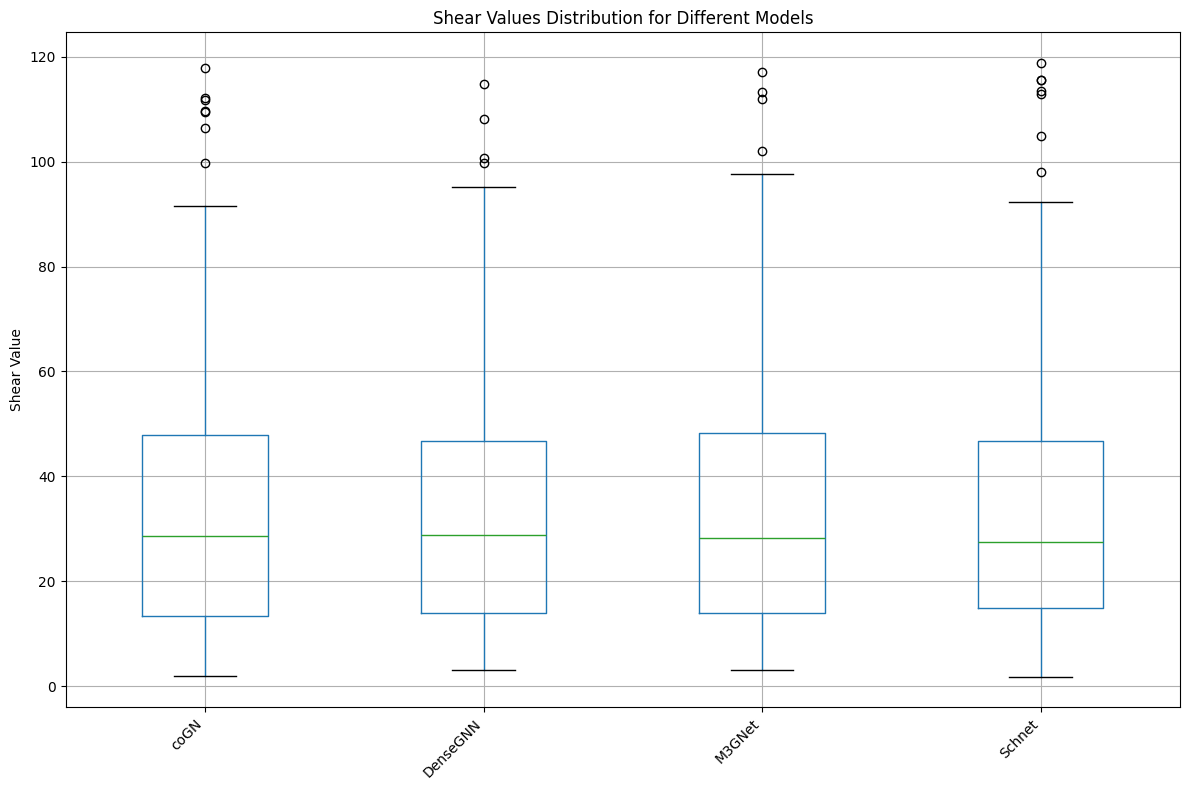

In [ ]:
# predict_elastic/bulk/文件夹中有 .json文件4个 分别是  predict_filter4_bulk_coGN.json ，predict_filter4_bulk_densegnn.json，
# predict_filter4_bulk_M3GNet.json，predict_filter4_bulk_Schnet.json

# 这些json文件的数据结构为 {
#     "mp-1185319": 18.63138198852539,
#     "mp-976280": 17.17385482788086,
#     "mp-1138": 56.1598129272460}，每个文件夹对应的 key都是一样的，只是value不一样，我现在想要读取四个json文件中的对应的每个id的value

# 这样得到 每个id:[4 个 bulk value]，然后绘制出4个折线图（分别是coGN，DenseGNN，M3GNet，Schnet），x轴为id，y轴为value，
# 请给出绘图代码


import json
import matplotlib.pyplot as plt
import pandas as pd

# 文件路径
folder_path = r'predict_elastic/shear/'
file_names = [
    'predict_filter4_shear_coGN.json',
    'predict_filter4_shear_densegnn.json',
    'predict_filter4_shear_M3GNet.json',
    'predict_filter4_shear_Schnet.json'
]

# 读取 JSON 文件
data = {}
for file_name in file_names:
    file_path = folder_path + file_name
    with open(file_path, 'r') as f:
        data[file_name] = json.load(f)

# 收集每个 mp_id 对应的四个 bulk value
bulk_values = {}
for mp_id in data[file_names[0]].keys():
    bulk_values[mp_id] = [data[file_name][mp_id] for file_name in file_names]

# 提取 mp_id 和对应的 bulk values
mp_ids = list(bulk_values.keys())
values_coGN = [bulk_values[mp_id][0] for mp_id in mp_ids]
values_densegnn = [bulk_values[mp_id][1] for mp_id in mp_ids]
values_M3GNet = [bulk_values[mp_id][2] for mp_id in mp_ids]
values_Schnet = [bulk_values[mp_id][3] for mp_id in mp_ids]

# 创建 DataFrame
df = pd.DataFrame({
    'coGN': values_coGN,
    'DenseGNN': values_densegnn,
    'M3GNet': values_M3GNet,
    'Schnet': values_Schnet
})

# 绘制箱线图
plt.figure(figsize=(12, 8))
df.boxplot()
plt.title('Shear Values Distribution for Different Models')
plt.ylabel('Shear Value')
plt.xticks(rotation=45, ha='right')
# plt.grid(True)
plt.tight_layout()
plt.show()

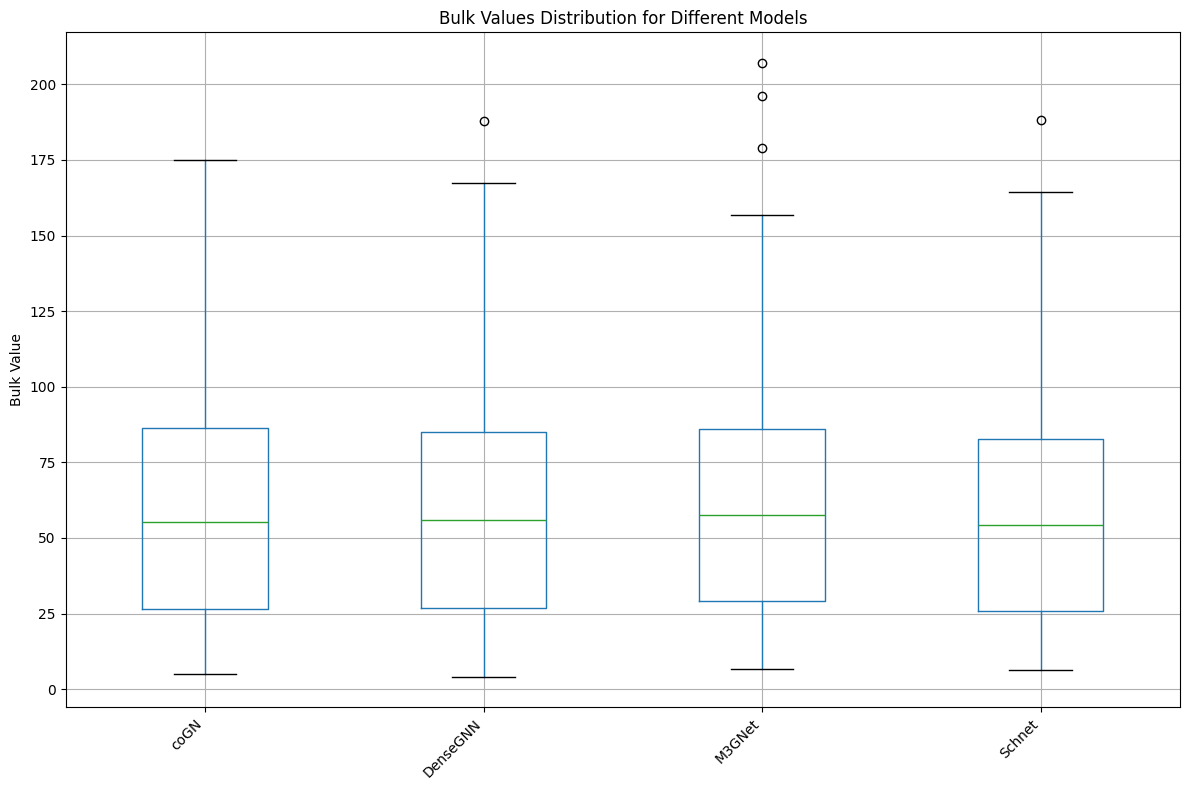

In [67]:
import json
import matplotlib.pyplot as plt
import pandas as pd

# 文件路径
folder_path = r'predict_elastic/bulk/'
file_names = [
    'predict_filter4_bulk_coGN.json',
    'predict_filter4_bulk_densegnn.json',
    'predict_filter4_bulk_M3GNet.json',
    'predict_filter4_bulk_Schnet.json'
]

# 读取 JSON 文件
data = {}
for file_name in file_names:
    file_path = folder_path + file_name
    with open(file_path, 'r') as f:
        data[file_name] = json.load(f)

# 收集每个 mp_id 对应的四个 bulk value
bulk_values = {}
for mp_id in data[file_names[0]].keys():
    bulk_values[mp_id] = [data[file_name][mp_id] for file_name in file_names]

# 提取 mp_id 和对应的 bulk values
mp_ids = list(bulk_values.keys())
values_coGN = [bulk_values[mp_id][0] for mp_id in mp_ids]
values_densegnn = [bulk_values[mp_id][1] for mp_id in mp_ids]
values_M3GNet = [bulk_values[mp_id][2] for mp_id in mp_ids]
values_Schnet = [bulk_values[mp_id][3] for mp_id in mp_ids]

# 创建 DataFrame
df = pd.DataFrame({
    'coGN': values_coGN,
    'DenseGNN': values_densegnn,
    'M3GNet': values_M3GNet,
    'Schnet': values_Schnet
})

# 绘制箱线图
plt.figure(figsize=(12, 8))
df.boxplot()
plt.title('Bulk Values Distribution for Different Models')
plt.ylabel('Bulk Value')
plt.xticks(rotation=45, ha='right')
# plt.grid(True)
plt.tight_layout()
plt.show()

## 草稿

In [ ]:
# ML Ered <1.0V, Eox>3.0V 筛选

import json
import numpy as np
from pymatgen.core import Composition, Element, Structure
from pymatgen.entries.compatibility import MaterialsProjectCompatibility
from pymatgen.entries.computed_entries import ComputedEntry
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter
from mp_api.client import MPRester

# 参数设置
API_KEY = 'iAihdZzrZYLQKZms1S43De90NiNK6ABB'

def load_structure_from_cif(cif_content):
    """从 CIF 内容加载结构文件并返回结构和组成信息"""
    structure = Structure.from_str(cif_content, fmt='cif')
    comp = structure.composition
    return structure, comp

def get_chemsys(comp):
    """根据组成信息获取化学系统字符串"""
    elements = sorted(comp.elements, key=lambda el: el.symbol)
    chemsys = "-".join([el.symbol for el in elements])
    return chemsys

def fetch_entries(rester, chemsys, mp_id):
    """从Materials Project获取条目"""
    mp_entries = rester.get_entries_in_chemsys(chemsys)
    entry = rester.get_entries(mp_id)[0]
    entries = [entry] + mp_entries
    return entries

def calculate_electrochemical_stability(pd, entry):
    """计算电化学稳定性"""
    li_entries = [e for e in entries if e.composition.reduced_formula == "Li"]
    uli0 = min(li_entries, key=lambda e: e.energy_per_atom).energy_per_atom

    el_profile = pd.get_element_profile(Element("Li"), entry.composition)
    voltages, reactions, evolutions = [], [], []

    for d in el_profile:
        voltage = -(d["chempot"] - uli0)
        voltages.append(voltage)
        reactions.append(d["reaction"])
        evolutions.append(d["evolution"])

    reduction_potential = min(voltages, key=lambda v: abs(evolutions[voltages.index(v)]))
    oxidation_potential = next((v for v, e in zip(voltages, evolutions) if e < -0.2), None)

    electrochemical_stability_window = (oxidation_potential - reduction_potential) if reduction_potential is not None and oxidation_potential is not None else 0
    return reduction_potential, oxidation_potential, electrochemical_stability_window

# def load_json_data(json_path):
#     """加载 JSON 数据"""
#     with open(json_path, 'r') as f:
#         data = json.load(f)
#     return data

def get_material_properties(rester, mp_id, cif_content):
    """获取材料的属性"""
    try:
        # 计算电化学稳定性
        structure, comp = load_structure_from_cif(cif_content)
        chemsys = get_chemsys(comp)
        entries = fetch_entries(rester, chemsys, mp_id)
        pd = PhaseDiagram(entries)
        reduction_potential, oxidation_potential, electrochemical_stability_window = calculate_electrochemical_stability(pd, entries[0])
        return {
         
            "reduction_potential": reduction_potential,
            "oxidation_potential": oxidation_potential,
            "electrochemical_stability_window": electrochemical_stability_window,
        }
    except Exception as e:
        print(f"Error fetching data for {mp_id}: {e}")
        return {}

# 主程序
if __name__ == "__main__":
    rester = MPRester(api_key=API_KEY)
    updated_data = {}

    for i, (mp_id, data) in enumerate(filtered_data_band_gap.items()):
        print(f"Processing mp_id: {mp_id}")
        cif_content = data.get("cif", "")
        if cif_content:
            properties = get_material_properties(rester, mp_id, cif_content)
            updated_data[mp_id] = {**data, **properties}
            # print(f"Updated data for {mp_id}: {updated_data[mp_id]}")
        else:
            print(f"未找到 {mp_id} 的 CIF 数据。")
        
        
    # 保存筛选后的数据到 filtered_2_band_gap.json 文件中
    with open('filtered_2_band_gap_red_oxi.json', 'w') as f:
        json.dump(filtered_data_band_gap, f, indent=4)
        

In [ ]:
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter
from pymatgen.core.composition import Composition

# 示例数据：化合物及其形成能（单位：eV/atom）
entries = [
    {"formula": "Li", "energy_per_atom": 0.0},  # 参考态
    {"formula": "O", "energy_per_atom": 0.0},    # 参考态
    {"formula": "Li2O", "energy_per_atom": -3.8},
    {"formula": "Li2O2", "energy_per_atom": -4.5},
    {"formula": "LiO", "energy_per_atom": -3.0},
]

# 创建Composition对象和对应的能量条目
from pymatgen.entries.computed_entries import ComputedEntry

entries = [
    ComputedEntry(Composition(entry["formula"]), entry["energy_per_atom"] * Composition(entry["formula"]).num_atoms)
    for entry in entries
]

# 创建相图
pd = PhaseDiagram(entries)

# 计算e above hull
e_above_hull = {entry.composition.reduced_formula: pd.get_e_above_hull(entry) for entry in entries}

# 打印结果
for formula, e_hull in e_above_hull.items():
    print(f"{formula}: {e_hull:.3f} eV/atom")

# 绘制相图
plotter = PDPlotter(pd)
plotter.show()

d:\ProgramData\envs\matgl\lib\site-packages\pymatgen\io\cif.py:1229: UserWarning: Issues encountered while parsing CIF: 4 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
d:\ProgramData\envs\matgl\lib\site-packages\pymatgen\io\cif.py:1229: UserWarning: Issues encountered while parsing CIF: 8 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
d:\ProgramData\envs\matgl\lib\site-packages\pymatgen\io\cif.py:1229: UserWarning: Issues encountered while parsing CIF: 6 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
d:\ProgramData\envs\matgl\lib\site-packages\pymatgen\io\cif.py:1229: UserWarning: Issues encountered while parsing CIF: 2

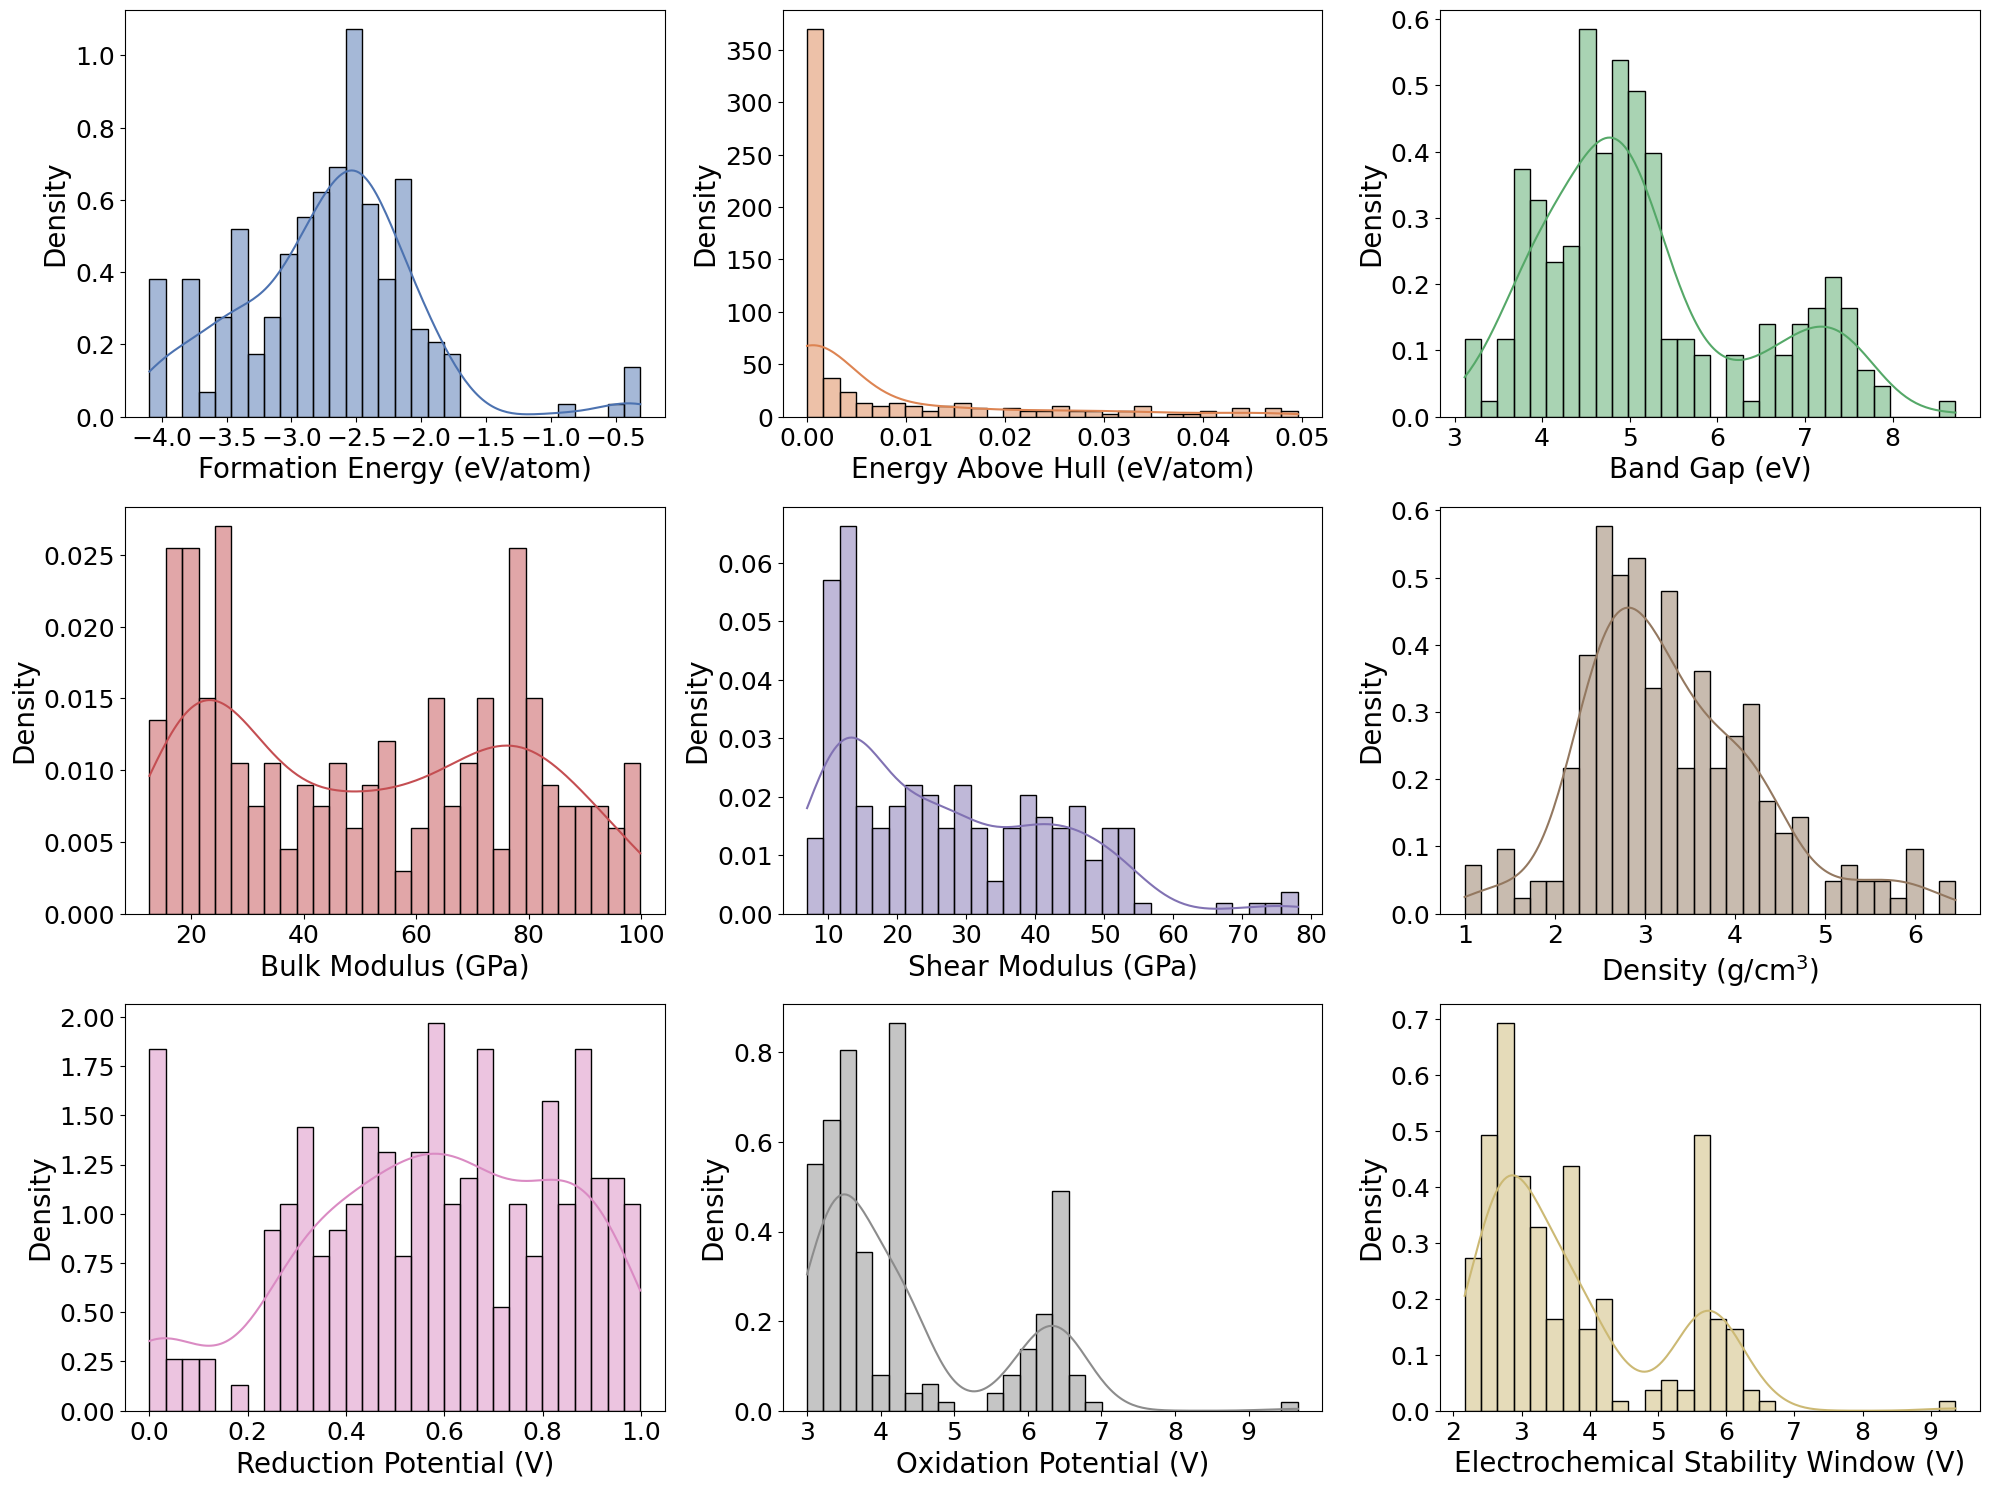

分布图已保存到 ./229_filtered_5_band_gap_red_oxi_ehull_elastic_100Gpa.png


In [2]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pymatgen.io.cif import CifParser
from pymatgen.core.structure import Structure

# 文件路径 232 candidate SSE before the uMLIP calculation

json_path = r'./filtered_5_band_gap_red_oxi_ehull_elastic_100Gpa.json'
output_image_path = r'./229_filtered_5_band_gap_red_oxi_ehull_elastic_100Gpa.png'

# json_path = r'./predicted/filtered_2_band_gap_red_oxi_mattersim_no_corrected.json'
# output_image_path = r'./plot/3198/3198_filtered_2_band_gap_red_oxi_mattersim_no_corrected.png'

# 读取 JSON 文件
with open(json_path, 'r') as f:
    data = json.load(f)

# 计算 density 字段
for entry in data.values():
    if 'cif' in entry:
        structure = Structure.from_str(entry['cif'], fmt='cif')
        entry['density'] = structure.density

# 选择需要绘制的字段
fields = [
    "formation_energy_per_atom", 
    "energy_above_hull",
    "band_gap",
    "bulk_modulus",
    "shear_modulus",
    "density",
    "reduction_potential",
    "oxidation_potential",
    "electrochemical_stability_window"
]

title_names = [
    "Formation Energy (eV/atom)",
    "Energy Above Hull (eV/atom)",
    "Band Gap (eV)",
    "Bulk Modulus (GPa)",
    "Shear Modulus (GPa)",
    r'Density (g/cm$^3$)',
    "Reduction Potential (V)",
    "Oxidation Potential (V)",
    "Electrochemical Stability Window (V)"
]


# 设置绘图参数
plt.figure(figsize=(20, 15))
# plt.figure(figsize=(20, 12))
n_fields = len(fields)
n_cols = 3
n_rows = (n_fields + n_cols - 1) // n_cols

# 设置论文常用的颜色
colors = sns.color_palette("deep", n_fields)

# 绘制每个字段的分布图
for i, field in enumerate(fields):
    plt.subplot(n_rows, n_cols, i + 1)
    values = [entry[field] for entry in data.values() if field in entry and entry[field] is not None]
    sns.histplot(values, kde=True, bins=30, stat="density", color=colors[i], edgecolor='black')
    # plt.title(title_names[i], fontsize=20)
    plt.xlabel(title_names[i], fontsize=20)
    plt.ylabel('Density', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

# 调整子图间距
plt.tight_layout()

# 保存图片
plt.savefig(output_image_path, dpi=300)
plt.show()

print(f"分布图已保存到 {output_image_path}")